In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

## First read in dataset

In [2]:
# recursive glob https://unix.stackexchange.com/questions/49913/recursive-glob
vehicles = glob.glob('training_data\\vehicles\\**\\*.png', recursive=True)
non_vehicles = glob.glob('training_data\\non-vehicles\\**\\*.png', recursive=True)

print('%d vehicles and %d non-vehicles in training set' % (len(vehicles), len(non_vehicles)))

8792 vehicles and 8968 non-vehicles in training set


## Implement functions used in lesson for pipeline

The functions used in the class are implemented below (sometimes slightly modified to fit this project).  Taken from lesson_functions.py in section 35 of Vehicle Detection and Tracking lesson.

In [8]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # add list to track found car bounding boxes
    found_cars = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                ul = (xbox_left, ytop_draw+ystart)
                br = (xbox_left+win_draw,ytop_draw+win_draw+ystart)
                cv2.rectangle(draw_img,ul,br,(0,0,255),6)
                found_cars.append((ul, br))
                
    return draw_img, found_cars
    

## Set parameters and split data

In [9]:
# Reduce the sample size while developing
#sample_size = 10
sample_size = -1
vehicles = vehicles[0:sample_size]
non_vehicles = non_vehicles[0:sample_size]

#print(vehicles)

In [5]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL" - find_cars hard-coded to all so must use all
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 12    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, None] # Min and max in y to search in slide_window()

car_features = extract_features(vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(non_vehicles, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

C:\Users\Larry\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 12 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7860


## Train classifier

In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

4.52 Seconds to train SVC...
Test Accuracy of SVC =  0.9885


## Test find_cars function against trained data

C:\Users\Larry\Anaconda3\envs\tensorflow-gpu\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


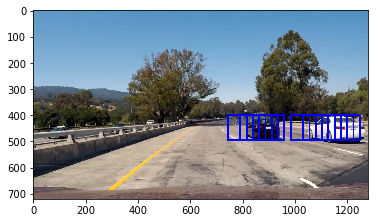

In [10]:
ystart = 400
ystop = 520
scale = 1.5
img = mpimg.imread('test_images/test1.jpg')

out_img, _ = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)
plt.show()

.\test_images\test1.jpg with ystart 400 ystop 520 scale 1.500000


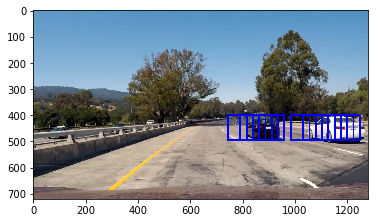

.\test_images\test1.jpg with ystart 400 ystop 520 scale 1.500000


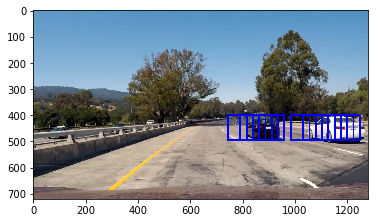

.\test_images\test1.jpg with ystart 400 ystop 680 scale 2.000000


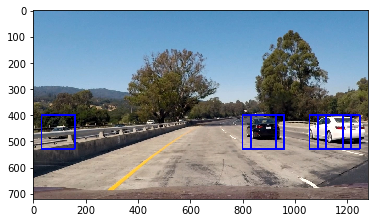

.\test_images\test2.jpg with ystart 400 ystop 520 scale 1.500000


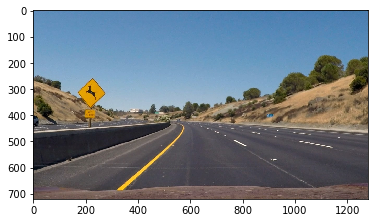

.\test_images\test2.jpg with ystart 400 ystop 520 scale 1.500000


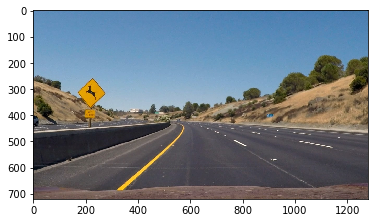

.\test_images\test2.jpg with ystart 400 ystop 680 scale 2.000000


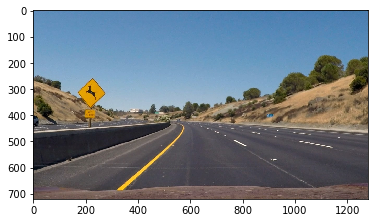

.\test_images\test3.jpg with ystart 400 ystop 520 scale 1.500000


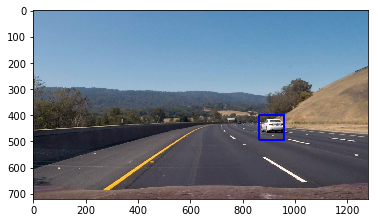

.\test_images\test3.jpg with ystart 400 ystop 520 scale 1.500000


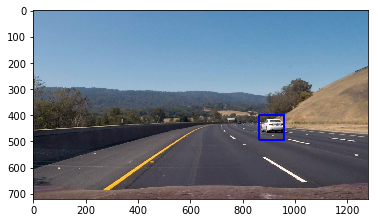

.\test_images\test3.jpg with ystart 400 ystop 680 scale 2.000000


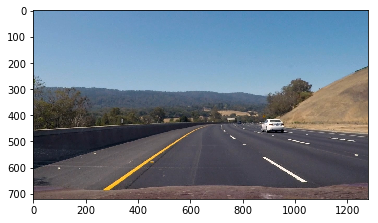

.\test_images\test4.jpg with ystart 400 ystop 520 scale 1.500000


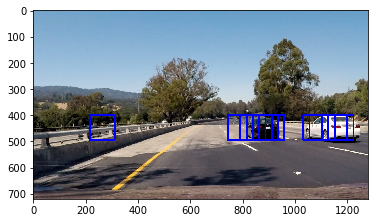

.\test_images\test4.jpg with ystart 400 ystop 520 scale 1.500000


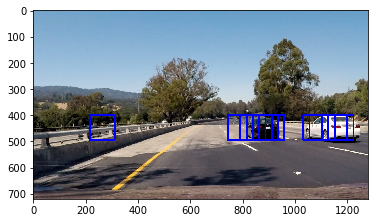

.\test_images\test4.jpg with ystart 400 ystop 680 scale 2.000000


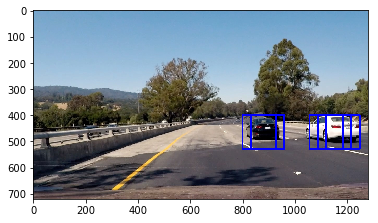

.\test_images\test5.jpg with ystart 400 ystop 520 scale 1.500000


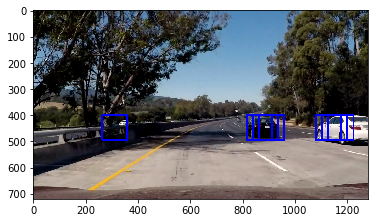

.\test_images\test5.jpg with ystart 400 ystop 520 scale 1.500000


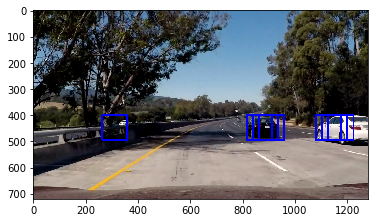

.\test_images\test5.jpg with ystart 400 ystop 680 scale 2.000000


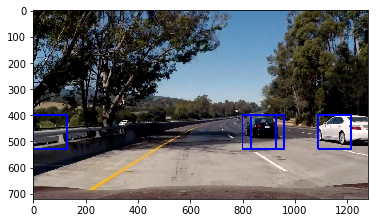

.\test_images\test6.jpg with ystart 400 ystop 520 scale 1.500000


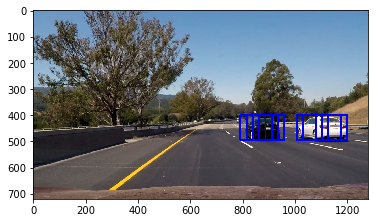

.\test_images\test6.jpg with ystart 400 ystop 520 scale 1.500000


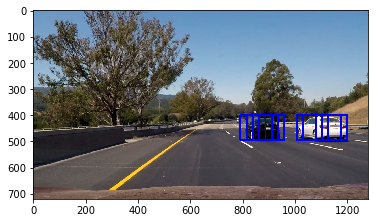

.\test_images\test6.jpg with ystart 400 ystop 680 scale 2.000000


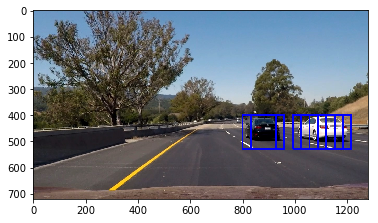

In [17]:
search_parameters = [
    {"ystart" : 400, "ystop" : 520, "scale" : 1.5},
    {"ystart" : 400, "ystop" : 680, "scale" : 2.0},
]

test_images = glob.glob(".\\test_images\\*.jpg")
#test_images = glob.glob(".\\test_images\\vlc*.png")
for file in test_images:
    img = mpimg.imread(file)
    
    for parameters in search_parameters:
        print("%s with ystart %d ystop %d scale %f" % (file, parameters["ystart"],parameters["ystop"],parameters["scale"]))
        out_img, _ = find_cars(img, parameters["ystart"], parameters["ystop"], parameters["scale"], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        plt.imshow(out_img)
        plt.show()

## Combine multiple detections via a heat map

First, bring in functions from section 37 of lesson.

In [12]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Function to draw heatmapped boxes

test_images\vlcsnap-error827.png


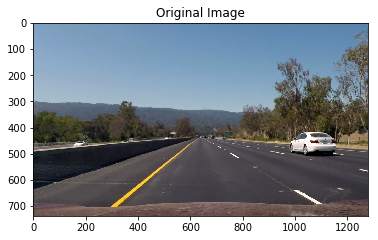

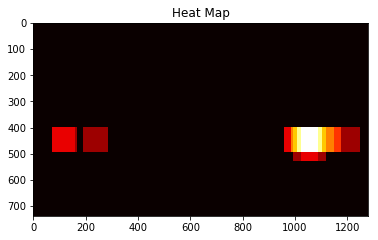

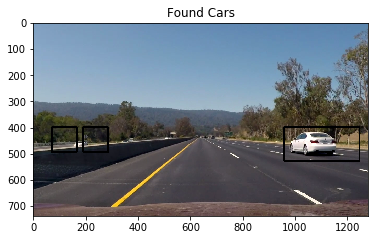

In [25]:
from scipy.ndimage.measurements import label

n_frames_tofollow = 5
last_n_frames_boxes = []

search_parameters = [
    {"ystart" : 400, "ystop" : 520, "scale" : 1.5},
    {"ystart" : 400, "ystop" : 520, "scale" : 1.5},
    {"ystart" : 400, "ystop" : 680, "scale" : 2.0},
]

def pipeline_find_heatmaps_and_draw(image, plot_frame=False, threshold_val=3):
    global last_n_frames_boxes
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # find cars primarily using parameters from above
    # adjusting scales and ystart/ystop to fine tune finding vehicles
    
    all_found_cars = []
    for parameters in search_parameters:
        out_img, found_cars = find_cars(image, parameters["ystart"], parameters["ystop"], parameters["scale"], svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

        all_found_cars.append(found_cars)
    
    #if len over limit, pop
    if len(last_n_frames_boxes) >= n_frames_tofollow:
        last_n_frames_boxes.pop(0)
    last_n_frames_boxes.append(all_found_cars)
    
    # go through last_n_frames_boxes
    for all_found in last_n_frames_boxes:
        for found_cars in all_found:
            # Add heat to each box in box list
            heat = add_heat(heat,found_cars)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold_val)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    if plot_frame:
        plt.imshow(image)
        plt.title('Original Image')
        plt.show()
        plt.imshow(heatmap, cmap='hot')
        plt.title('Heat Map')
        plt.show()
        plt.imshow(draw_img)
        plt.title('Found Cars')
        plt.show()

    return draw_img
    
file = 'test_images\\vlcsnap-error827.png'
image = mpimg.imread(file)
print(file)
found_cars_img = pipeline_find_heatmaps_and_draw(image, plot_frame=True, threshold_val=1)

In [14]:
## Process movie

In [15]:
from moviepy.editor import VideoFileClip

last_n_frames_boxes = []
clip_output = 'test_video_output.mp4'
clip = VideoFileClip("test_video.mp4")
processed_clip = clip.fl_image(pipeline_find_heatmaps_and_draw) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:14<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 14.8 s


In [16]:
from moviepy.editor import VideoFileClip

last_n_frames_boxes = []
clip_output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")
processed_clip = clip.fl_image(pipeline_find_heatmaps_and_draw) #NOTE: this function expects color images!!
%time processed_clip.write_videofile(clip_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [07:54<00:00,  2.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 7min 54s
